# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training, when using batched PCA function
n_pca_batches = 10 # number of batches, when using batched PCA function

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=16

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 27s, sys: 6.51 s, total: 1min 34s
Wall time: 1min 34s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 

# USE_FIRST_N_CELLS = 1000000
# adata = adata[0:USE_FIRST_N_CELLS]
# adata.shape

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 2min 32s, sys: 37.3 s, total: 3min 10s
Wall time: 3min 10s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 1min 2s, sys: 18.5 s, total: 1min 20s
Wall time: 1min 20s


In [10]:
adata.shape

(1291337, 24002)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 9.05 s, sys: 1.84 s, total: 10.9 s
Wall time: 10.9 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 39.8 s, sys: 0 ns, total: 39.8 s
Wall time: 39.8 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 30 s, sys: 52.5 ms, total: 30.1 s
Wall time: 30 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 35.9 s, sys: 2.14 s, total: 38.1 s
Wall time: 38.1 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 2min 15s, sys: 3min 15s, total: 5min 31s
Wall time: 9min 29s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1min 2s, sys: 4.25 s, total: 1min 6s
Wall time: 1min 6s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 1025.5210211277008


## Cluster & Visualize

### Reduce

For a fair comparison with the single-GPU notebook, we calculate the time taken if we use the PCA function from `utils.py`, which uses only a fraction of the cells for training.

In [18]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)

CPU times: user 21min 18s, sys: 2min 53s, total: 24min 12s
Wall time: 44.3 s


In [19]:
# To perform PCA on the whole dataset:
# %%time
# sc.tl.pca(adata, n_comps=n_components)

### TSNE + K-means

In [20]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 6h 42min 39s, sys: 25.7 s, total: 6h 43min 4s
Wall time: 1h 48min 29s


In [21]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=sc.settings.n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 30min 28s, sys: 28min 45s, total: 59min 13s
Wall time: 2min 28s


... storing 'kmeans' as categorical


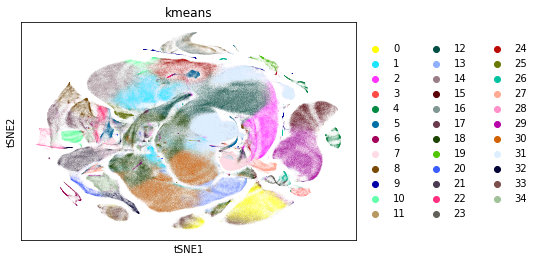

CPU times: user 6.57 s, sys: 944 ms, total: 7.51 s
Wall time: 7.51 s


In [22]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

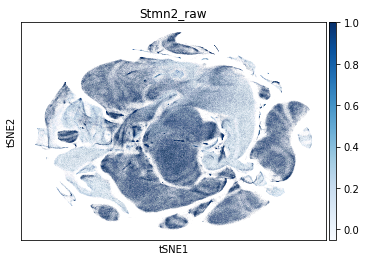

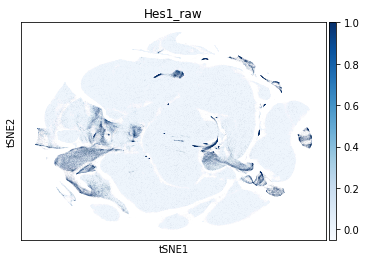

CPU times: user 7.31 s, sys: 39.5 ms, total: 7.35 s
Wall time: 7.35 s


In [23]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [24]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 25min 2s, sys: 32min 51s, total: 57min 53s
Wall time: 2min 34s


In [25]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 7h 48min 26s, sys: 1h 47min 46s, total: 9h 36min 12s
Wall time: 42min 51s


In [26]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 19min 11s, sys: 5.47 s, total: 19min 16s
Wall time: 19min 13s


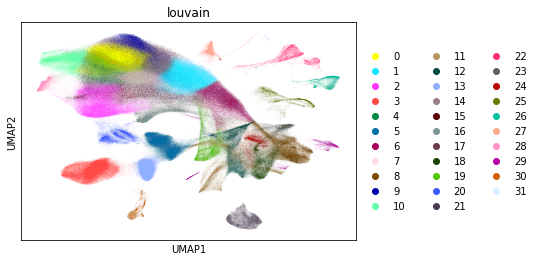

CPU times: user 6.43 s, sys: 17.2 ms, total: 6.45 s
Wall time: 6.44 s


In [27]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [28]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 1h 43min 35s, sys: 2min 28s, total: 1h 46min 3s
Wall time: 1h 45min 45s


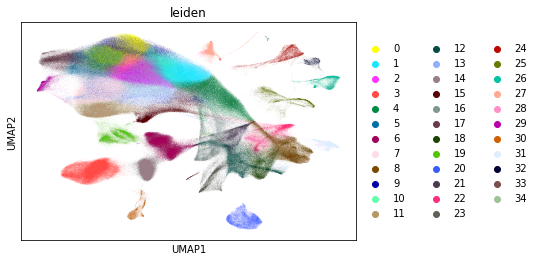

CPU times: user 6.63 s, sys: 71.1 ms, total: 6.7 s
Wall time: 6.7 s


In [29]:
%%time
sc.pl.umap(adata, color=["leiden"])

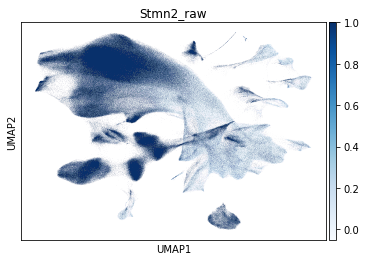

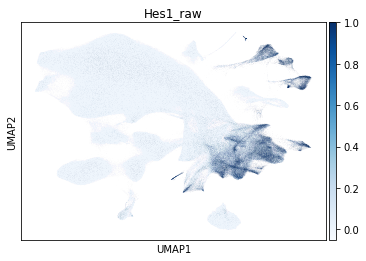

CPU times: user 7.54 s, sys: 22.9 ms, total: 7.56 s
Wall time: 7.56 s


In [30]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(120309, 4000)
CPU times: user 6.84 s, sys: 364 ms, total: 7.21 s
Wall time: 7.2 s


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 22min 11s, sys: 7min 53s, total: 30min 4s
Wall time: 4min 6s


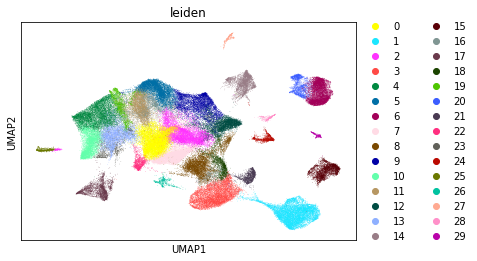

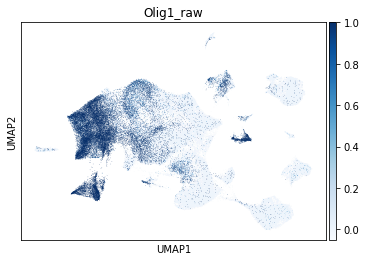

CPU times: user 1.69 s, sys: 79.2 ms, total: 1.77 s
Wall time: 1.77 s


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 255.18219304084778


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 18337.897437095642
